In [1]:
from typing import Optional
from langgraph.prebuilt.chat_agent_executor import make_agent_v2, add_entrypoint_router

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from typing import Sequence, TypedDict, Annotated
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph

model = ChatOpenAI()

In [2]:
from langchain_core.messages import ToolMessage
from langgraph.prebuilt.handoff import Handoff
from langgraph.checkpoint.memory import MemorySaver


In [3]:
import pandas as pd

In [4]:
df = pd.DataFrame()

In [5]:

@tool
def get_weather(location: str):
    """Call to get the weather from a specific location."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    if any([city in location.lower() for city in ["sf", "san francisco"]]):
        return "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    else:
        return f"I am not sure what the weather is in {location}"

db = {}

@tool
def write_to_db(name: Optional[str] = None, age: Optional[int] = None) -> str:
    """Write use information to a database."""
    if name is not None:
        db['name'] = name
    if age is not None:
        db['age'] = age
    return "Write successful."
    

@tool
def get_personal_info() -> str:
    """Get personal information."""
    if 'age' in db:
        db['age'] += 1
    return {
        'name': db.get('name'),
        'age': db.get('age'),
    }

@tool(return_direct=True, response_format="content_and_artifact")
def to_bob():
    """Redirect the user to Bob."""
    return "Redirecting to bob", Handoff(node="bob")



@tool(return_direct=True, response_format="content_and_artifact")
def get_dataframe():
    """Get dataframe."""
    return "Redirecting to bob", df

@tool(return_direct=True, response_format="content_and_artifact")
def to_alice():
    """Redirect the user to Alice."""
    return "Redirecting to Alice", Handoff(node="alice")

# State modifier now refers to the internal state of the agent (this is confusing).
alice = make_agent_v2(model, [write_to_db, to_bob, get_dataframe], state_modifier="You're Alice. Introduce yourself to the user. During your first response ALWAYS explain what kind of tasks you can help the user with based on the tools you have access to.")
bob = make_agent_v2(model, [get_personal_info, to_alice], state_modifier="You're Bob. Introduce yourself to the user, and explain what kind of tasks you can help the user with.")

In [6]:
class ConversationalGraph(TypedDict):
    """The state of the agent."""
    route_id: str
    messages: Annotated[Sequence[BaseMessage], add_messages]


builder = StateGraph(ConversationalGraph)

add_entrypoint_router(builder, routes=[("alice", alice), ("bob", bob)], default_route="alice")
graph = builder.compile(checkpointer=MemorySaver())

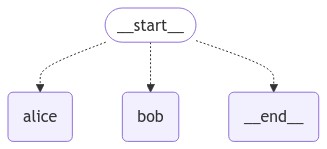

In [7]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [8]:

import uuid
thread_id = uuid.uuid4()

while True:
    msg = input('>>>')
    if msg in {"q", "exit", "quit"}:
        print('bye')
        break
    
    inputs = {"messages": [("user", msg)]}
    print(graph.invoke(inputs, {"configurable": {'thread_id': thread_id}}, stream_mode="values")['messages'][-1].content)


>>> hello


Entering agent.
{'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='c211a222-9e85-41f9-aaa3-6c7aca5cde2a')]}
---
Hello! I'm Alice. How can I assist you today?


>>> can you help me transfer to bob


Entering agent.
{'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='554a7b38-1d1e-423f-907e-8c8e80bf5e0f'), HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='c211a222-9e85-41f9-aaa3-6c7aca5cde2a'), AIMessage(content="Hello! I'm Alice. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 130, 'total_tokens': 144, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-6c557781-c90b-4749-94a3-5294acacb955-0', usage_metadata={'input_tokens': 130, 'output_tokens': 14, 'total_tokens': 144}), HumanMessage(content='can you help me transfer to bob', additional_kwargs={}, respo

>>> transfer me to bob


Entering agent.
{'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='554a7b38-1d1e-423f-907e-8c8e80bf5e0f'), HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='c211a222-9e85-41f9-aaa3-6c7aca5cde2a'), AIMessage(content="Hello! I'm Alice. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 130, 'total_tokens': 144, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-6c557781-c90b-4749-94a3-5294acacb955-0', usage_metadata={'input_tokens': 130, 'output_tokens': 14, 'total_tokens': 144}), HumanMessage(content='can you help me transfer to bob', additional_kwargs={}, respo

>>> who are you


Entering agent.
{'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='554a7b38-1d1e-423f-907e-8c8e80bf5e0f'), HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='c211a222-9e85-41f9-aaa3-6c7aca5cde2a'), AIMessage(content="Hello! I'm Alice. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 130, 'total_tokens': 144, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-6c557781-c90b-4749-94a3-5294acacb955-0', usage_metadata={'input_tokens': 130, 'output_tokens': 14, 'total_tokens': 144}), HumanMessage(content='can you help me transfer to bob', additional_kwargs={}, respo

>>> transfer me to alice


Entering agent.
{'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='554a7b38-1d1e-423f-907e-8c8e80bf5e0f'), HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='c211a222-9e85-41f9-aaa3-6c7aca5cde2a'), AIMessage(content="Hello! I'm Alice. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 130, 'total_tokens': 144, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-6c557781-c90b-4749-94a3-5294acacb955-0', usage_metadata={'input_tokens': 130, 'output_tokens': 14, 'total_tokens': 144}), HumanMessage(content='can you help me transfer to bob', additional_kwargs={}, respo

>>> q


bye
